## Required Essential Libraries ##


In [ ]:
!pip install tensorflow
!pip install datasets
!pip install transformers[torch]==4.31.0
!pip install huggingface-hub
!pip install nltk
!pip install rouge-score
!pip install evaluate

## Dataset Preparation ##

In [37]:
import os
import logging
import tqdm as notebook_tqdm
from datasets import load_dataset
import tensorflow as tf

raw_xsum_dataset = load_dataset("EdinburghNLP/xsum", split = 'train', trust_remote_code= 'True')

tf.get_logger().setLevel(logging.ERROR)

os.environ['TOKENIZERS_PARALLELISM'] = 'False'

In [38]:
sub_xsum_dataset = raw_xsum_dataset.select(range(50000))

In [39]:
print(sub_xsum_dataset)

Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 50000
})


In [40]:
print(sub_xsum_dataset[0])

{'document': 'The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.\nRepair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.\nTrains on the west coast mainline face disruption due to damage at the Lamington Viaduct.\nMany businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.\nFirst Minister Nicola Sturgeon visited the area to inspect the damage.\nThe waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.\nJeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.\nHowever, she said more preventative work could have been carried out to ensure the retaining wall did not fail.\n"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally apprecia

In [41]:
split_xsum_dataset=sub_xsum_dataset.train_test_split(train_size=0.7)

In [42]:
print(split_xsum_dataset['train'][0])

{'document': "The 22-year-old has joined on a one-year deal with the option of a second, and is Barrow's sixth summer signing.\nHe started his career at Fulham before moving to QPR where he failed to make a first-team appearance.\nFitzpatrick moved to Wimbledon in 2014 but only played 13 games, and had a loan spell in the National League with Torquay last term, scoring three goals.\nFind all the latest football transfers on our dedicated page.", 'summary': 'National League club Barrow have signed winger David Fitzpatrick following his release by AFC Wimbledon.', 'id': '40432537'}


# Data Preprocessing #
## Text Splitter ##

In [43]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")

In [44]:
def tokenize_function(examples):
    inputs = [doc if doc is not None else "" for doc in examples['document']]
    summaries = [summ if summ is not None else "" for summ in examples['summary']]
    
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True, padding="max_length")
    
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(summaries, max_length=128, truncation=True, padding="max_length")
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [45]:
tokenized_datasets = split_xsum_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

/opt/anaconda3/envs/text_summary/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

## Model Definition ##

In [46]:
from transformers import AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-small")

### Data Collator ###

In [47]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model="google-t5/t5-small")

### Evaluate Model ###

In [14]:
pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached evaluate-0.4.2-py3-none-any.whl.metadata (9.3 kB)
Using cached evaluate-0.4.2-py3-none-any.whl (84 kB)
Note: you may need to restart the kernel to use updated packages.


In [48]:
import evaluate
rouge = evaluate.load('rouge')

In [49]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
pip install tf-keras

In [50]:
from transformers import TrainerCallback
class ExtendedMetricsCallback(TrainerCallback):
    def __init__(self):
        self.metrics = {
            "epoch": [],
            "eval_rouge1": [],
            "eval_rouge2": [],
            "eval_rougeL": [],
        }
        
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            epoch = logs.get("epoch")
            eval_rouge1 = logs.get("eval_rouge1")
            eval_rouge2 = logs.get("eval_rouge2")
            eval_rougeL = logs.get("eval_rougeL")
            

            if epoch is not None:
                self.metrics["epoch"].append(epoch)
            if eval_rouge1 is not None:
                self.metrics["eval_rouge1"].append(eval_rouge1)
            if eval_rouge2 is not None:
                self.metrics["eval_rouge2"].append(eval_rouge2)
            if eval_rougeL is not None:
                self.metrics["eval_rougeL"].append(eval_rougeL)


In [26]:
import torch
if torch.backends.mps.is_available():
    device = "mps"
    print("Using Apple Silicon (MPS) device for training.")
else:
    print("MPS device not available. Falling back to CPU.")
    device = "cpu"

Using Apple Silicon (MPS) device for training.


In [53]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, TrainingArguments, Trainer
import torch 

if torch.backends.mps.is_available():
    device = "mps"
    print(f"Using MPS device: {device}")
else:
    print("MPS device not available. Falling back to CPU.")
    device = "cpu"

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=10,
    fp16 = True,
    use_cpu = False
)

extended_metrics_callback = ExtendedMetricsCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[extended_metrics_callback]
)

trainer.train()


Using MPS device: mps


  0%|          | 0/21880 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [6]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Define paths
model_path = './best_saved_model_10'  
tokenizer_path = './best_saved_token_10'  

# Load the model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

# Example prompt (input text) for summarization
input_text = "You will be responsible for managing the way that your Direct Payments are spent. This means that if you employ a Personal Assistant directly, you will be classed as their employer."

# Tokenize the input text
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

# Generate the summary (adjust max_length and num_beams as needed)
summary_ids = model.generate(input_ids, max_length=150, num_beams=4, length_penalty=2.0, early_stopping=True)

# Decode the generated summary
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Print the generated summary
print("Generated Summary:", summary)

Generated Summary: You will be responsible for managing the way your Direct Payments are spent, if you employ a Personal Assistant.


In [ ]:

# Extract metrics from callback
epochs = extended_metrics_callback.metrics["epoch"]
eval_rouge1 = extended_metrics_callback.metrics["eval_rouge1"]
eval_rouge2 = extended_metrics_callback.metrics["eval_rouge2"]
eval_rougeL = extended_metrics_callback.metrics["eval_rougeL"]

print(f'Epochs: {epochs}'/n)
print(f'Rouge - 1 Score: {eval_rouge1}'/n)
print(f'Rouge - 2 Score: {eval_rouge2}'/n)
print(f'Rouge - L Score: {eval_rougeL}'/n)

# Model Summary #

In [20]:
from transformers import AutoModel, AutoConfig
import os

def load_custom_model(model_path):
    # Load the model using AutoModel from transformers
    model = AutoModel.from_pretrained(model_path)
    return model

def summarize_custom_model(model_path, output_file):
    # Load your model using the function defined above
    model = load_custom_model(model_path)
    
    # Open the file in write mode and keep it open for all writing operations
    with open(output_file, 'w') as f:
        # Get basic information
        model_type = f"Model type: {type(model).__name__}\n"
        f.write(model_type)
    
        # Load and print the config
        config = AutoConfig.from_pretrained(model_path)
        config_str = f"Model configuration:\n{config}\n"
        f.write(config_str)
    
        # Print model parameters
        total_params = sum(p.numel() for p in model.parameters())
        total_param_str = f"Total parameters: {total_params}\n"
        f.write(total_param_str)

# Use the function
summarize_custom_model('best_saved_model_10', 'summary_gen_model.txt')

Model summary saved as summary_gen_model.png


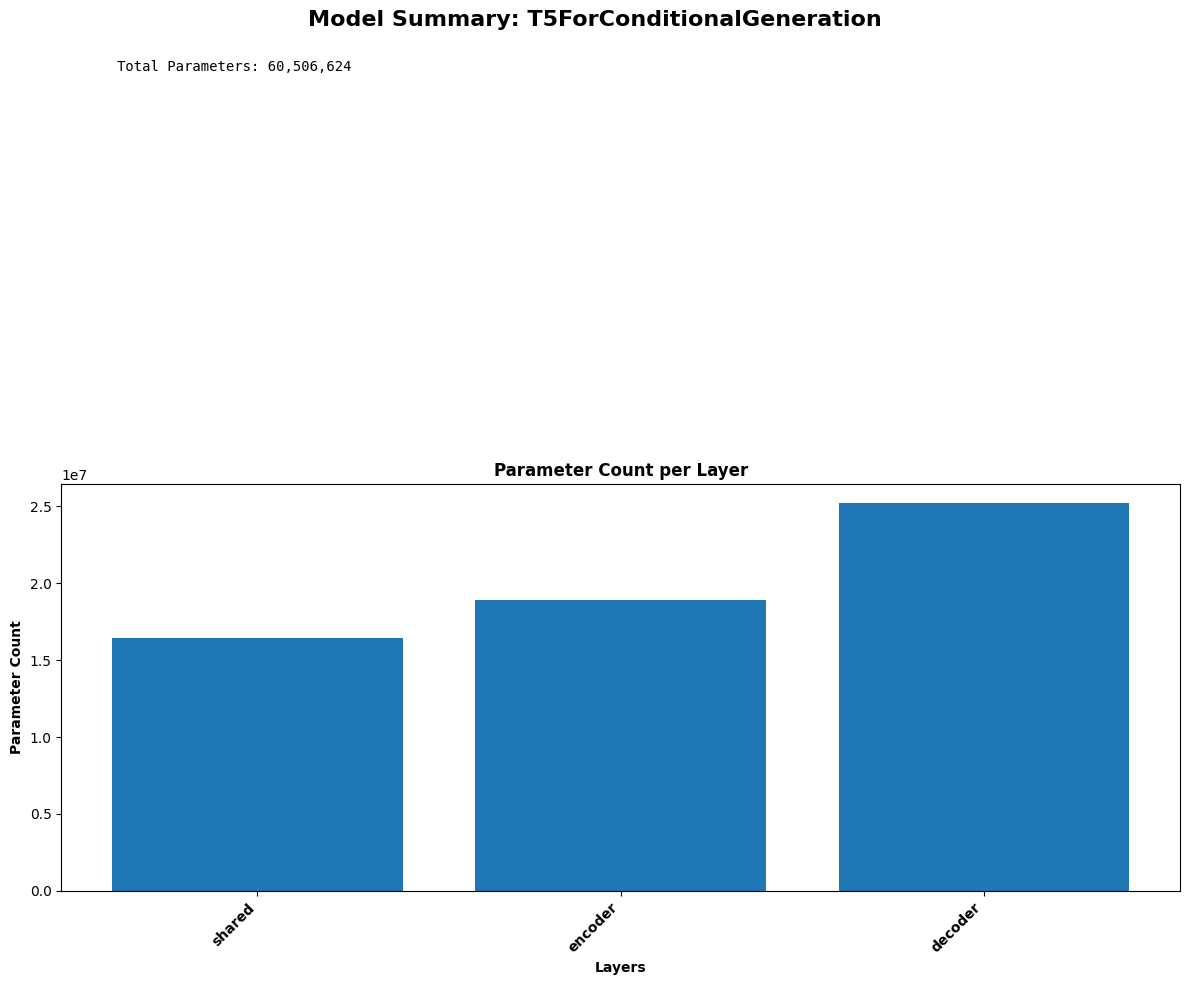

In [25]:
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoConfig
import os
import io

def create_model_summary_image(model_path, output_file='summary_gen_model.png'):
    # Load the model and config
    model = AutoModel.from_pretrained(model_path)
    config = AutoConfig.from_pretrained(model_path)
    
    # Gather model details
    model_type = type(model).__name__
    total_params = sum(p.numel() for p in model.parameters())
    config_dict = config.to_dict()
    files_in_directory = os.listdir(model_path)

    # Create the figure and axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle(f"Model Summary: T5ForConditionalGeneration", fontsize=16, fontweight='bold')

    # Model info text
    info_text = f"Total Parameters: {total_params:,}"

    ax1.text(0.05, 0.95, info_text, verticalalignment='top', fontsize=10, 
             family='monospace', transform=ax1.transAxes)
    ax1.axis('off')

    # Bar chart of parameter counts per layer
    layer_params = {}
    for name, param in model.named_parameters():
        layer = name.split('.')[0]
        layer_params[layer] = layer_params.get(layer, 0) + param.numel()

    layers = list(layer_params.keys())
    counts = list(layer_params.values())

    ax2.bar(layers, counts)
    ax2.set_title("Parameter Count per Layer", fontweight='bold')
    ax2.set_xlabel("Layers", fontweight='bold')
    ax2.set_ylabel("Parameter Count", fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontweight='bold')

    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Model summary saved as {output_file}")

# Use the function
create_model_summary_image('best_saved_model_10')